### Learning to rank with XGB - more data


- 1 Million rows

- loss considers NDCG

- Feature and row selection as in https://docs.google.com/document/d/1R9itgngZUNzkBqWzXstLiBXXoYJa8-ahS66JrqC3kDk/edit

- after feature selection: check for queries with one row/no click/transaction
- preprocessed: no queries with only one result, numerical variables scaled
- click and transaction in one relevance label (click weight: 1, transaction weight: 2)



code folllows this example: https://xgboost.readthedocs.io/en/stable/tutorials/learning_to_rank.html

In [59]:
import pandas as pd
df = pd.read_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/processed/MillionRows/millionrows_Top500Destinations.csv')

In [60]:
df.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,...,True,False,True,False,False,False,False,False,False,False
1,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,...,True,False,True,True,False,False,False,True,False,False
2,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,...,True,False,True,True,True,False,False,True,False,True
3,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,...,False,False,True,True,True,False,False,False,False,True
4,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,...,False,False,True,True,True,False,False,False,False,False


In [61]:
df.shape

(2049518, 49)

In [62]:
df.dtypes

user_id                        int64
search_id                      int64
point_of_sale                  int64
geo_location_country           int64
is_mobile                      int64
destination_id                 int64
checkin_date                  object
checkout_date                 object
adult_count                    int64
child_count                    int64
infant_count                   int64
room_count                     int64
sort_type                     object
length_of_stay               float64
booking_window               float64
search_day_of_week             int64
search_hour_of_day             int64
checkin_day                    int64
checkout_day                   int64
rank                           int64
prop_id                        int64
is_travel_ad                   int64
review_rating                float64
review_count                 float64
star_rating                   object
is_free_cancellation           int64
is_drr                         int64
p

In [63]:
# how many queries in test data?
len(df["search_id"].unique())

75642

In [64]:
len(df["user_id"].unique())

48716

#### drop columns not needed - first step

In [65]:
df = df.drop(columns = ["search_day_of_week", "search_hour_of_day",
                        "checkout_date", "infant_count", "room_count", "rank",
                        "user_id"])

df.shape

(2049518, 42)

In [66]:
## create relvance label
# 1 for clicked on
# 2 for transaction

df["relevance"] = 0  # Initialize with default value
df.loc[df["num_clicks"] > 0, "relevance"] = 1  # Set value to 1 if first_column > 0
df.loc[df["is_trans"] > 0, "relevance"] = 2  # Add 2 if second_column > 0


In [67]:
### drop num clicks and is_trans
df = df.drop(columns = ["is_trans", "num_clicks"])
df.shape

(2049518, 41)

In [68]:
#### barplot of relevance labels
import matplotlib.pyplot as plt
frequency_counts = df["relevance"].value_counts()

In [69]:
frequency_counts

relevance
0    1908184
1     131053
2      10281
Name: count, dtype: int64

#### Drop rows based on conditions - new data set object is created

In [70]:
## what are values in sort_type
df["sort_type"].value_counts()

sort_type
RECOMMENDED                      1881566
PRICE ASCENDING                   107997
STAR RATING DESCENDING             15118
GUEST RATINGS DESCENDING           14661
SPECIAL - DIRECT HOTEL SEARCH      11913
DEALS                              10316
VACATION RENTAL                     7947
Name: count, dtype: int64

In [71]:
# drop everything that is not sort_type == RECOMMENDED
df_model = df[df["sort_type"] == "RECOMMENDED"]
df_model.shape

(1881566, 41)

In [72]:
#### are there sort_type other than recommended
df_model["sort_type"].value_counts()

sort_type
RECOMMENDED    1881566
Name: count, dtype: int64

In [73]:
df_model = df_model.drop(columns = "sort_type")

In [74]:
df_model["star_rating"].value_counts()

star_rating
4.0              715088
3.0              627137
5.0              283367
2.0              133366
0                 85191
Not Available     36587
1.0                 793
0.0                  37
Name: count, dtype: int64

In [75]:
### remove Not Available and transfer to integer
df_model = df_model[df_model["star_rating"] != "Not Available"]
df_model["star_rating"].value_counts()

star_rating
4.0    715088
3.0    627137
5.0    283367
2.0    133366
0       85191
1.0       793
0.0        37
Name: count, dtype: int64

In [76]:
# transfer star rating to a numeric value
df_model["star_rating"] = pd.to_numeric(df_model["star_rating"])

In [77]:
df_model["star_rating"].value_counts()

star_rating
4.0    715088
3.0    627137
5.0    283367
2.0    133366
0.0     85228
1.0       793
Name: count, dtype: int64

In [78]:
df_model["review_rating"].value_counts()

review_rating
4.0    1206031
5.0     493645
3.0     107968
0.0      27600
2.0       9032
1.0        703
Name: count, dtype: int64

In [79]:
## remove if review rating == 0, because indicates that no rating could be given
df_model = df_model[df_model["review_rating"] != 0.0]
df_model["review_rating"].value_counts()

review_rating
4.0    1206031
5.0     493645
3.0     107968
2.0       9032
1.0        703
Name: count, dtype: int64

In [80]:
## rows without valid values are already dropped with review_rating
df_model['review_count'].value_counts()

review_count
1025.0     358711
1000.0     156005
25.0       116550
50.0        46534
75.0        35742
            ...  
22100.0         3
27775.0         3
14325.0         2
27750.0         2
14675.0         1
Name: count, Length: 747, dtype: int64

In [81]:
df_model['price_bucket'].value_counts()

price_bucket
4.0    389951
3.0    383366
2.0    369453
5.0    354746
1.0    319863
Name: count, dtype: int64

In [82]:
import numpy as np

In [83]:
df_model["price_bucket"].mean()

3.049667130521482

#### Exclude ads

In [84]:
df_model['is_travel_ad'].value_counts()

is_travel_ad
0    1633412
1     183967
Name: count, dtype: int64

In [85]:
# only rows that are no ads stay in df
df_model = df_model[df_model['is_travel_ad'] == 0]
df_model.shape

(1633412, 40)

In [86]:
df_model = df_model.drop(columns = "is_travel_ad")

In [87]:
df_model['rank_noad'].value_counts()

rank_noad
2.0     67698
3.0     67037
1.0     66633
4.0     66430
5.0     65730
        ...  
70.0        1
71.0        1
73.0        1
82.0        1
83.0        1
Name: count, Length: 82, dtype: int64

#### Extract month from checkin_date

In [88]:
df_model["in_date"] = pd.to_datetime(df_model["checkin_date"])
df_model["in_date"]

0         2021-07-07
3         2021-07-07
4         2021-07-07
5         2021-07-07
6         2021-07-07
             ...    
2049513   2021-06-21
2049514   2021-06-21
2049515   2021-06-21
2049516   2021-06-21
2049517   2021-06-21
Name: in_date, Length: 1633412, dtype: datetime64[ns]

In [89]:
# Extract the month
df_model["checkin_month"] = df_model["in_date"].dt.month

In [90]:
# transform month to category
df_model["checkin_month"] = df_model["checkin_month"].astype("category")

In [91]:
# drop string and date time of checkin
df_model = df_model.drop(columns = ["checkin_date", "in_date"])

#### Transform amenities from string into category

In [92]:
### replace True False strings with 1 and 0

df_model = df_model.replace({"True": 1, "False": 0})

In [93]:
df_model.head()

,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,length_of_stay,booking_window,checkin_day,...,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance,checkin_month
0,2,1,1,0,49,2,0,5.0,26.0,2,...,1,0,0,0,0,0,0,0,1,7
3,2,1,1,0,49,2,0,5.0,26.0,2,...,1,1,1,0,0,0,0,1,0,7
4,2,1,1,0,49,2,0,5.0,26.0,2,...,1,1,1,0,0,0,0,0,0,7
5,2,1,1,0,49,2,0,5.0,26.0,2,...,1,0,1,0,0,0,0,0,0,7
6,2,1,1,0,49,2,0,5.0,26.0,2,...,1,1,0,0,0,0,0,0,0,7


In [94]:
amenities =  ['AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi']



# change type to category:
for amenity in amenities:
  df_model[amenity] = df_model[amenity].astype('int')

In [95]:
# df_model['is_mobile'] = df_model['is_mobile'].astype('category')
# df_model['is_free_cancellation'] = df_model['is_free_cancellation'].astype('category')
# df_model['is_drr'] = df_model['is_drr'].astype('category')
df_model['checkin_day'] = df_model['checkin_day'].astype('category')
df_model['checkout_day'] = df_model['checkout_day'].astype('category')

In [96]:
df_amenities = pd.read_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/processed/MillionRows/amenities.tsv.gz', compression='gzip', sep='\t')

In [97]:
df_model['number_of_amenities'] = df_model[df_amenities.columns.difference(['prop_id'])].sum(axis=1)

In [98]:
df_model.dtypes

search_id                       int64
point_of_sale                   int64
geo_location_country            int64
is_mobile                       int64
destination_id                  int64
adult_count                     int64
child_count                     int64
length_of_stay                float64
booking_window                float64
checkin_day                  category
checkout_day                 category
prop_id                         int64
review_rating                 float64
review_count                  float64
star_rating                   float64
is_free_cancellation            int64
is_drr                          int64
price_bucket                  float64
rank_noad                     float64
AirConditioning                 int64
AirportTransfer                 int64
Bar                             int64
FreeAirportTransportation       int64
FreeBreakfast                   int64
FreeParking                     int64
FreeWiFi                        int64
Gym         

In [99]:
## keep only integer/float columns for XGB
df_model.head()

,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,length_of_stay,booking_window,checkin_day,...,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance,checkin_month,number_of_amenities
0,2,1,1,0,49,2,0,5.0,26.0,2,...,0,0,0,0,0,0,0,1,7,5
3,2,1,1,0,49,2,0,5.0,26.0,2,...,1,1,0,0,0,0,1,0,7,6
4,2,1,1,0,49,2,0,5.0,26.0,2,...,1,1,0,0,0,0,0,0,7,6
5,2,1,1,0,49,2,0,5.0,26.0,2,...,0,1,0,0,0,0,0,0,7,6
6,2,1,1,0,49,2,0,5.0,26.0,2,...,1,0,0,0,0,0,0,0,7,4


In [100]:
categorical_features = df_model.select_dtypes(include=['category']).columns.tolist()
# numeric_features = df_model.select_dtypes(exclude=['category']).columns.tolist()


categorical_features

['checkin_day', 'checkout_day', 'checkin_month']

In [101]:
df_model.shape

(1633412, 40)

In [102]:
# drop rows with NaN values
# there should be no more rows dropped
df_model = df_model.dropna()

df_model.shape

(1633412, 40)

In [103]:
#### check data before test - train split

# are there qids with only one row?
# throw out rows where qid is unique - for those ndcg is not possible to calculate
# Find counts of each group
group_counts = df_model["search_id"].value_counts()
unique_groups = group_counts[group_counts == 1].index

filtered_df = df_model[~df_model["search_id"].isin(unique_groups)]
filtered_df.shape

(1633131, 40)

In [104]:
df_model = filtered_df

In [105]:
df_model=df_model[df_model['rank_noad']<=30]

In [106]:
df_model['rank_noad'].max()

30.0

#### Train test split

- check here for qids with only one row/ queries with only zeros in relevance

In [195]:
from sklearn.model_selection import GroupShuffleSplit

def split_by_qid(df, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df[df['search_id'].isin(ids[train_idx])], df[df['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df_model, test_size=0.3)

train_df.shape, test_df.shape

((1140941, 40), (490731, 40))

In [196]:
# data needs to be ordered by qid for XGBRank function
train_df = train_df.sort_values(by = "search_id")
X_train = train_df.drop(columns = ["search_id", "relevance"])


# feature names for plots later on
#features_list = X.columns.tolist()

# scale features
#X = normalize(X)

# relevance label is outcome var
y_train = train_df["relevance"]
qid_train = train_df["search_id"]

In [197]:
print(X_train.shape), print(train_df.shape)

(1140941, 38)
(1140941, 40)


(None, None)

In [52]:
X_train.dtypes

point_of_sale                   int64
geo_location_country            int64
is_mobile                       int64
destination_id                  int64
adult_count                     int64
child_count                     int64
length_of_stay                float64
booking_window                float64
checkin_day                  category
checkout_day                 category
review_rating                 float64
review_count                  float64
star_rating                   float64
is_free_cancellation            int64
is_drr                          int64
price_bucket                  float64
rank_noad                     float64
AirConditioning                 int64
AirportTransfer                 int64
Bar                             int64
FreeAirportTransportation       int64
FreeBreakfast                   int64
FreeParking                     int64
FreeWiFi                        int64
Gym                             int64
HighSpeedInternet               int64
HotTub      

In [53]:
# same data format for test data
test_df = test_df.sort_values(by = "search_id")

X_test = test_df.drop(columns = ["search_id", "relevance"])

#X_test = normalize(X_test)

y_test = test_df["relevance"]
qid_test = test_df["search_id"]

In [108]:
test_df.columns

Index(['search_id', 'point_of_sale', 'geo_location_country', 'is_mobile',
       'destination_id', 'adult_count', 'child_count', 'length_of_stay',
       'booking_window', 'checkin_day', 'checkout_day', 'prop_id',
       'review_rating', 'review_count', 'star_rating', 'is_free_cancellation',
       'is_drr', 'price_bucket', 'rank_noad', 'AirConditioning',
       'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast',
       'FreeParking', 'FreeWiFi', 'Gym', 'HighSpeedInternet', 'HotTub',
       'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool',
       'SpaServices', 'SwimmingPool', 'WasherDryer', 'WiFi', 'relevance',
       'checkin_month', 'number_of_amenities'],
      dtype='object')

In [56]:
X_test.shape

(490731, 37)

In [55]:
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['category']).columns.tolist()

# take out destination ID and geo_location_country and point_of_sale from list so it can be encoded separately
numeric_features.remove("destination_id")
numeric_features.remove("geo_location_country")
numeric_features.remove("point_of_sale")


categorical_features, numeric_features

(['checkin_day', 'checkout_day', 'checkin_month'],
 ['is_mobile',
  'adult_count',
  'child_count',
  'length_of_stay',
  'booking_window',
  'review_rating',
  'review_count',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket',
  'rank_noad',
  'AirConditioning',
  'AirportTransfer',
  'Bar',
  'FreeAirportTransportation',
  'FreeBreakfast',
  'FreeParking',
  'FreeWiFi',
  'Gym',
  'HighSpeedInternet',
  'HotTub',
  'LaundryFacility',
  'Parking',
  'PetsAllowed',
  'PrivatePool',
  'SpaServices',
  'SwimmingPool',
  'WasherDryer',
  'WiFi',
  'number_of_amenities'])

#### Feature pre-processing

In [56]:
!pip install -q category_encoders

In [57]:
import sklearn
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
### encode categorical with high cardinality
sklearn.set_config(transform_output="pandas")
from category_encoders.target_encoder import TargetEncoder



In [58]:
### encode destination ID and geo_location_country and point_of_sale
enc = TargetEncoder(cols=["destination_id", "geo_location_country", "point_of_sale"]).fit(X_train, y_train)

X_train = enc.transform(X_train)
X_test = enc.transform(X_test)

/home/constructor/.conda/envs/expedia_310/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/constructor/.conda/envs/expedia_310/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/constructor/.conda/envs/expedia_310/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarni

In [59]:
X_train.dtypes

point_of_sale                 float64
geo_location_country          float64
is_mobile                       int64
destination_id                float64
adult_count                     int64
child_count                     int64
length_of_stay                float64
booking_window                float64
checkin_day                  category
checkout_day                 category
review_rating                 float64
review_count                  float64
star_rating                   float64
is_free_cancellation            int64
is_drr                          int64
price_bucket                  float64
rank_noad                     float64
AirConditioning                 int64
AirportTransfer                 int64
Bar                             int64
FreeAirportTransportation       int64
FreeBreakfast                   int64
FreeParking                     int64
FreeWiFi                        int64
Gym                             int64
HighSpeedInternet               int64
HotTub      

In [60]:
# remove ordinal features before scaling of numeric
# most binary features are already 0, 1 encoded

numeric_features = ['adult_count',
 'child_count',
 'length_of_stay',
 'booking_window',
 'review_count','number_of_amenities']

numeric_features, categorical_features

(['adult_count',
  'child_count',
  'length_of_stay',
  'booking_window',
  'review_count',
  'number_of_amenities'],
 ['checkin_day', 'checkout_day', 'checkin_month'])

In [61]:
# scale numerical
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [62]:
# create dummies for categorical

X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

In [63]:
X_train.head()

,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,length_of_stay,booking_window,review_rating,review_count,...,checkin_month_3,checkin_month_4,checkin_month_5,checkin_month_6,checkin_month_7,checkin_month_8,checkin_month_9,checkin_month_10,checkin_month_11,checkin_month_12
0,0.072668,0.073436,0,0.060411,-0.213111,-0.345988,0.855712,-0.24261,4.0,-0.043638,...,False,False,False,False,True,False,False,False,False,False
25,0.072668,0.073436,0,0.060411,-0.213111,-0.345988,0.855712,-0.24261,4.0,-0.092394,...,False,False,False,False,True,False,False,False,False,False
26,0.072668,0.073436,0,0.060411,-0.213111,-0.345988,0.855712,-0.24261,5.0,0.122134,...,False,False,False,False,True,False,False,False,False,False
27,0.072668,0.073436,0,0.060411,-0.213111,-0.345988,0.855712,-0.24261,5.0,-0.248415,...,False,False,False,False,True,False,False,False,False,False
19,0.072668,0.073436,0,0.060411,-0.213111,-0.345988,0.855712,-0.24261,4.0,-0.131399,...,False,False,False,False,True,False,False,False,False,False


In [144]:
len(y_test)

490731

In [66]:
y_test.to_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0423_60C_te/y_test.csv', index=False)


In [84]:
X_train.shape

(1140941, 60)

In [86]:
from sklearn.datasets import dump_svmlight_file

# Save X_train as SVMLight file with .txt extension
file_path_train = '/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0423_60C_te/train.txt'
dump_svmlight_file(X_train, y_train, f=file_path_train, query_id=qid_train)

# Save X_valid as SVMLight file with .txt extension
#file_path_valid = '/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0423_32C_te/vali.txt'
#dump_svmlight_file(X_valid, y_valid, f=file_path_valid, query_id=qid_valid)

# Save X_test as SVMLight file with .txt extension
file_path_test = '/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0423_60C_te/test.txt'
dump_svmlight_file(X_test, y_test, f=file_path_test, query_id=qid_test)

In [1]:
pwd

'/home/constructor/FinalProjects/Expedia_new/allRank_WS/notebooks'

In [11]:
import pandas as pd
y_pred = pd.read_csv("/home/constructor/FinalProjects/Expedia_new/allRank_WS/predictions_c2te30.txt", delimiter='\t')
scores = pd.read_csv("/home/constructor/FinalProjects/Expedia_new/allRank_WS/scores_c2te30.txt", delimiter='\t')
test_df=pd.read_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0426_61C_propid_te/test_df.csv')

In [12]:
y_pred[y_pred == -1] = np.nan
y_pred.columns = [str(i) for i in range(1, 31)]
scores.columns = [str(i) for i in range(1, 31)]
scores.replace([float('-inf')], float('nan'), inplace=True)
scores

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,-77.113892,-82.385521,-19.952787,-69.618195,-79.528488,-53.948128,0.674535,-22.336454,-7.378111,104.141159,...,-90.148911,-87.706612,-68.893105,-41.865234,-58.038200,NaN,NaN,NaN,NaN,NaN
1,-61.594612,-64.734032,-75.001968,-60.243393,-82.599884,-85.891571,-89.765182,-60.602066,103.722992,-91.197166,...,-67.737595,-85.864517,10.384970,-78.475449,-91.458344,-85.846359,3.891736,-88.211426,-75.837151,-75.764786
2,-70.869408,-75.074356,103.269409,24.560591,-35.710037,-6.882389,31.370621,15.125010,-70.952789,15.277156,...,-14.196272,6.851134,-80.494614,-77.628662,NaN,NaN,NaN,NaN,NaN,NaN
3,34.574722,18.002529,20.464928,-59.773331,-68.832771,15.351674,23.696218,-51.864403,3.568534,-73.723022,...,-77.216278,-43.759766,-29.213408,-3.989656,NaN,NaN,NaN,NaN,NaN,NaN
4,103.235687,-62.921715,-87.557732,-67.362381,-75.615517,-73.052261,-47.856590,-64.651527,-83.435806,-53.289238,...,-51.546230,-9.000542,-41.418743,-63.503178,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,-35.969803,-79.767303,-80.994247,-78.341614,103.922737,-89.936859,-1.020204,-57.197838,-67.534798,-70.231911,...,-56.745056,-57.657799,-95.806107,-87.534332,NaN,NaN,NaN,NaN,NaN,NaN
20639,100.582108,-77.927841,-68.684799,-21.223452,-77.298401,-82.731293,-58.817215,-48.230377,-79.698135,-54.233719,...,-64.759796,-82.588058,-74.873077,-53.761215,-70.276756,NaN,NaN,NaN,NaN,NaN
20640,-95.025528,-56.876411,-89.687729,-82.484528,-93.039116,9.056068,-87.327896,-98.092560,-91.618927,-80.694160,...,-61.522766,-12.063461,-98.055420,-84.910652,-57.432678,NaN,NaN,NaN,NaN,NaN
20641,-22.297876,-46.293007,-46.616962,-93.888794,-79.840561,-92.253822,103.255783,-71.058594,-26.007292,-88.740540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_df.columns

Index(['search_id', 'point_of_sale', 'geo_location_country', 'is_mobile',
       'destination_id', 'adult_count', 'child_count', 'length_of_stay',
       'booking_window', 'checkin_day', 'checkout_day', 'prop_id',
       'review_rating', 'review_count', 'star_rating', 'is_free_cancellation',
       'is_drr', 'price_bucket', 'rank_noad', 'AirConditioning',
       'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast',
       'FreeParking', 'FreeWiFi', 'Gym', 'HighSpeedInternet', 'HotTub',
       'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool',
       'SpaServices', 'SwimmingPool', 'WasherDryer', 'WiFi', 'relevance',
       'checkin_month', 'number_of_amenities'],
      dtype='object')

In [15]:
flat_y_pred = y_pred.values.flatten()
flat_scores = scores.values.flatten()
df_ground=test_df[['search_id', 'prop_id','relevance','rank_noad']]

In [8]:
# append scores to test_df 
# Group by search_id
grouped = df_ground.groupby('search_id')

# Create an empty list to store the data
appended_data = []

# Iterate over each group
for name, group in grouped:
    # Append the existing rows
    appended_data.append(group)
    # Calculate the number of missing rows to reach 30
    missing_rows = 30 - len(group)
    if missing_rows > 0:
        # Append missing rows with NaN relevance
        missing_rows_df = pd.DataFrame({
            'search_id': [name] * missing_rows,
            'prop_id': [None] * missing_rows,
            'relevance': [None] * missing_rows
        })
        appended_data.append(missing_rows_df)

# Concatenate the data
df_ground_new = pd.concat(appended_data, ignore_index=True)

In [16]:
# Count occurences of {0, 1, 2} in y_pred
pred_counts = pd.Series(flat_y_pred).value_counts().reindex([0, 1, 2]).fillna(0)

# Count occurrences of relevance in y_test
test_counts = df_ground['relevance'].value_counts().reindex([0, 1, 2]).fillna(0)

# Print the counts
print("Relevance counts in y_pred:")
print(pred_counts)

print("\nRelevance counts in y_test:")
print(test_counts)

Relevance counts in y_pred:
0    457986
1     30299
2      2418
Name: count, dtype: int64

Relevance counts in y_test:
relevance
0    458011
1     30302
2      2418
Name: count, dtype: int64


In [43]:
pd.set_option('display.max_columns', None)
import pandas as pd

# Pivoting the DataFrame
pivot_df = pd.pivot_table(df_ground, index='search_id', columns=df_ground.groupby('search_id').cumcount() + 1, values='relevance', aggfunc='first')

# If there are less than 30 columns, pad NaN
if pivot_df.shape[1] < 30:
    pad_columns = range(pivot_df.shape[1] + 1, 31)
    for col in pad_columns:
        pivot_df[col] = pd.NA

# Resetting index
pivot_df.reset_index(drop=True,inplace=True)

#pivot_df=pivot_df.reset_index(drop=True)
pivot_df=pivot_df.iloc[1:].reset_index(drop=True)


In [40]:
#test_df.iloc[0:60]
# Let's check for search_ids: 79, 113 and 119

,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,length_of_stay,booking_window,checkin_day,checkout_day,prop_id,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance,checkin_month,number_of_amenities
0,79,1,1,1,184,2,0,1.0,17.0,0,0,166371,5.0,50.0,0.0,1,0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6,1
1,79,1,1,1,184,2,0,1.0,17.0,0,0,327866,4.0,1200.0,3.0,1,1,4.0,6.0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,6,5
2,79,1,1,1,184,2,0,1.0,17.0,0,0,4376703,4.0,175.0,4.0,1,0,4.0,5.0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,6,6
3,79,1,1,1,184,2,0,1.0,17.0,0,0,3112590,5.0,50.0,0.0,1,1,4.0,4.0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,6,5
4,79,1,1,1,184,2,0,1.0,17.0,0,0,3931739,4.0,825.0,4.0,1,1,2.0,7.0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,6,6
5,79,1,1,1,184,2,0,1.0,17.0,0,0,2569597,4.0,575.0,3.0,1,1,2.0,10.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,6,3
6,79,1,1,1,184,2,0,1.0,17.0,0,0,1862879,4.0,950.0,2.0,1,1,2.0,11.0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,6,4
7,79,1,1,1,184,2,0,1.0,17.0,0,0,1969041,5.0,100.0,0.0,1,0,5.0,12.0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,6,5
8,79,1,1,1,184,2,0,1.0,17.0,0,0,3982061,4.0,1025.0,3.0,1,1,2.0,26.0,1,0,0,0,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,6,9
9,79,1,1,1,184,2,0,1.0,17.0,0,0,5124392,4.0,250.0,2.0,0,1,2.0,25.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,6,4


In [42]:
#test_df[test_df['search_id']==119][['search_id', 'relevance','rank_noad']]

,search_id,relevance,rank_noad
53,119,0,6.0
54,119,0,7.0
55,119,0,13.0
56,119,0,12.0
57,119,0,11.0
58,119,0,10.0
59,119,0,9.0
60,119,0,8.0
61,119,0,27.0
62,119,0,28.0


In [44]:
pivot_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
20641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(len(df_ground_new)), print(len(flat_scores)), len(flat_y_pred)

619320
619290


(None, None, 619290)

In [202]:
# Get the minimum length of the DataFrame and the list/array
min_length = min(len(df_ground_new), len(flat_scores))
min_length

df_ground_new=df_ground_new.iloc[:min_length]

# Add the 'prop_id' values from the DataFrame to the corresponding elements in flat_y_pred up to the minimum length
df_ground_new['flat_scores'] = flat_scores

In [226]:
# Group by 'search_id' and rank based on 'flat_scores' in descending order
df_ground_new['rank_pred'] = df_ground_new.groupby('search_id')['flat_scores'].rank(method='dense', ascending=False)

# Convert 'rank_pred' column to integer type
df_ground_new['rank_pred'] = df_ground_new['rank_pred'].astype('Int64')
df_ground_new['relevance_pred']=flat_y_pred

df_ground_new

KeyError: 'Column not found: flat_scores'

In [206]:
df_filtered=df_ground_new.dropna()

In [207]:
df_filtered

,search_id,prop_id,relevance,rank_noad,flat_scores,rank_pred
0,79,166371,0,3.0,-77.113892,14
1,79,3112590,0,4.0,-82.385521,18
2,79,4376703,0,5.0,-19.952787,4
3,79,327866,0,6.0,-69.618195,13
4,79,3931739,0,7.0,-79.528488,17
...,...,...,...,...,...,...
619272,999191,4158265,0,21.0,-70.717659,10
619273,999191,6996825,0,22.0,-90.945023,22
619274,999191,2788476,0,24.0,-41.394966,5
619275,999191,1650407,0,26.0,-87.618027,17


In [208]:
from scipy.stats import kendalltau

# Assuming df_ground_new is your DataFrame

# Drop rows with NaN values in 'rank_noad' and 'rank_pred'
df_eval = df_ground_new.dropna(subset=['rank_noad', 'rank_pred'])

# Calculate Kendall's tau
tau, _ = kendalltau(df_eval['rank_noad'], df_eval['rank_pred'])

print("Kendall's Tau:", tau)


Kendall's Tau: 0.07499806282406794


In [211]:
y_pred2=y_pred.copy()

In [212]:
len(y_pred)

20643

In [220]:
# Group by search_id
grouped = df_ground.groupby('search_id')

# Create an empty list to store the data
appended_data = []

# Iterate over each group
for name, group in grouped:
    # Append the existing rows
    appended_data.append(group)
    # Calculate the number of missing rows to reach 30
    missing_rows = 30 - len(group)
    if missing_rows > 0:
        # Append missing rows with NaN relevance
        missing_rows_df = pd.DataFrame({
            'search_id': [name] * missing_rows,
            'prop_id': [None] * missing_rows,
            'relevance': [None] * missing_rows
        })
        appended_data.append(missing_rows_df)

# Concatenate the data
df_ground_new = pd.concat(appended_data, ignore_index=True)


In [221]:
df_ground_new

,search_id,prop_id,relevance,rank_noad
0,79,166371,0,3.0
1,79,3112590,0,4.0
2,79,4376703,0,5.0
3,79,327866,0,6.0
4,79,3931739,0,7.0
...,...,...,...,...
619315,999200,None,None,NaN
619316,999200,None,None,NaN
619317,999200,None,None,NaN
619318,999200,None,None,NaN


In [222]:
# Get the minimum length of the DataFrame and the list/array
min_length = min(len(df_ground_new), len(flat_y_pred))

# Add the 'prop_id' values from the DataFrame to the corresponding elements in flat_y_pred up to the minimum length
pred_df = df_ground_new['prop_id'].iloc[:min_length] + flat_y_pred[:min_length]

In [35]:
print(pred_df.shape), print(df_ground_trim.shape)

(619290,)
(619290,)


(None, None)

In [233]:
pivot_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20639,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20640,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
y_pred2

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20639,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20640,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
20641,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Saving file for rbo calculations ##

In [238]:

import numpy as np
y_prediction = np.nan_to_num(y_pred2, nan=-1)
y_true = np.nan_to_num(pivot_df, nan=-1)

def ndcg(y_score_indices, y_true, k):
    y_true_sorted = np.take(y_true, y_score_indices[:k])

    gain = 2 ** y_true_sorted - 1

    discounts = np.log2(np.arange(len(y_true_sorted)) + 2)
    return np.sum(gain / discounts)

# Usage:
y_prediction_indices = np.argsort(y_prediction)
ndcg_score1 = ndcg(y_prediction_indices, y_true, 30)

# Compare NDCG scores
print("NDCG Score for y_pred:", ndcg_score1)

NDCG Score for y_pred: 1.2791408100266206


In [ ]:
rbo_allrank=pd.DataFrame(np.argsort(np.array(scores_list)).tolist())

rbo_allrank.to_csv('/home/constructor/FinalProjects/Expedia_new/allRank_WS/expedia_data/0426_61C_propid_te/rbo_allrank.csv', index=False)

In [ ]:
import xgboost as xgb

In [ ]:
# use the examplary code from xgboost documentation as a starting point:
# https://xgboost.readthedocs.io/en/stable/python/examples/learning_to_rank.html#sphx-glr-python-examples-learning-to-rank-py
# specifically for click data

ranker = xgb.XGBRanker(
        n_estimators=100, #512
        tree_method="hist",
        device="cuda",
        learning_rate=0.01,
        reg_lambda=0.05,
        subsample=0.8,
        sampling_method="gradient_based",
        # to handle categorical features with many features
        #enable_categorical=True,
        # above 7 categories no one hot encoding
        #max_cat_to_onehot = 7,
        #max_cat_threshold = 15,
        # LTR specific parameters
        objective="rank:ndcg",
        # - Enable bias estimation
        lambdarank_unbiased=True,
        # - normalization (1 / (norm + 1))
        lambdarank_bias_norm=1,
        # - Focus on the top 12 documents
        lambdarank_num_pair_per_sample=12,
        lambdarank_pair_method="topk",
        ndcg_exp_gain=True,
        eval_metric=["ndcg@1", "ndcg@3", "ndcg@5", "ndcg@10", "ndcg@50"],
        lambdarank_normalization = False
 )

In [ ]:
# ranker = xgb.XGBRanker(
#        n_estimators=1000,
#        learning_rate=0.1,
#        objective='rank:pairwise', # this is RankNet loss or the pairwise logistic loss
#        lambdarank_num_pair_per_sample=25,
#        lambdarank_pair_method="topk",
#        reg_lambda=0.05,
#        # verbose = True,
#        tree_method = 'hist',
#        eval_metric = 'ndcg',
#        eta = 0.3
#    )



In [ ]:
corr = X_train[["point_of_sale", "geo_location_country", "is_mobile",
                "destination_id", "adult_count", "child_count", "length_of_stay",
                "booking_window", "review_rating", "review_count", "star_rating",
                "is_free_cancellation", "is_drr", "price_bucket",
                "rank_noad"]].corr(numeric_only=True)

<Axes: >

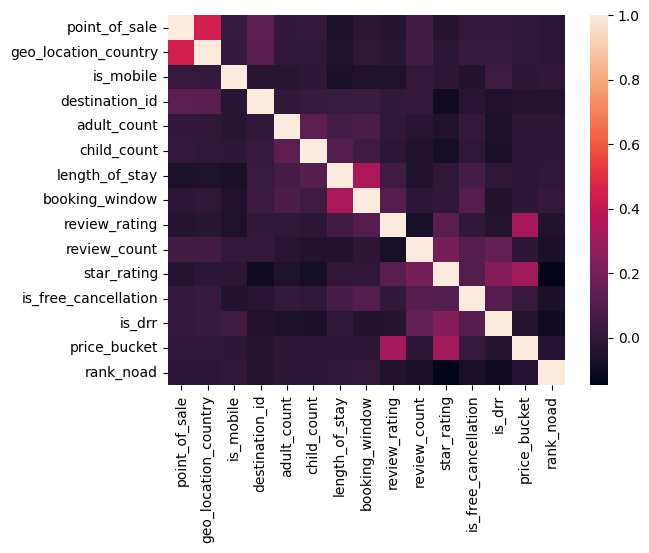

In [ ]:
import seaborn as sns
sns.heatmap(corr)

In [ ]:
# fit on training data

ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_test, y_test)],
    eval_qid=[qid_test],
    verbose = True,
    early_stopping_rounds = 15
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:42:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambdarank_normalization" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-ndcg@1:0.49390	validation_0-ndcg@3:0.53307	validation_0-ndcg@5:0.56915	validation_0-ndcg@10:0.62194	validation_0-ndcg@50:0.68061
[1]	validation_0-ndcg@1:0.49311	validation_0-ndcg@3:0.53727	validation_0-ndcg@5:0.57317	validation_0-ndcg@10:0.62474	validation_0-ndcg@50:0.68236
[2]	validation_0-ndcg@1:0.49356	validation_0-ndcg@3:0.53847	validation_0-ndcg@5:0.57405	validation_0-ndcg@10:0.62550	validation_0-ndcg@50:0.68290
[3]	validation_0-ndcg@1:0.49415	validation_0-ndcg@3:0.53861	validation_0-ndcg@5:0.57463	validation_0-ndcg@10:0.62592	validation_0-ndcg@50:0.68328
[4]	validation_0-ndcg@1:0.49377	validation_0-ndcg@3:0.53908	validation_0-ndcg@5:0.57438	validation_0-ndcg@10:0.62600	validation_0-ndcg@50:0.68327
[5]	validation_0-ndcg@1:0.49420	validation_0-ndcg@3:0.53926	validation_0-ndcg@5:0.57471	validation_0-ndcg@10:0.62656	validation_0-ndcg@50:0.68354
[6]	validation_0-ndcg@1:0.49372	validation_0-ndcg@3:0.53890	validation_0-ndcg@5:0.57464	validation_0-ndcg@10:0.62611	validat

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='cuda',
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=['ndcg@1', 'ndcg@3', 'ndcg@5', 'ndcg@10', 'ndcg@50'],
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_bias_norm=1, lambdarank_normalization=False,
          lambdarank_num_pair_per_sample=12, lambdarank_pair_method='topk',
          lambdarank_unbiased=True, learning_rate=0.01, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=None, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, ...)

In [ ]:
#ranker.evals_result_

In [ ]:
# from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
# Works with cv in scikit-learn, along with HPO utilities like GridSearchCV
# kfold = StratifiedGroupKFold(n_splits = 5, shuffle=False)

# what is the default scoring for XGBRanker -> is it eval_metric from the model above

# cross_val_score(ranker, X, y, cv=kfold, groups=X.qid)

Prediction: needs to be done by query in query_test

---

To do:
- calculate a scores by query, then calculate ndcg for each query
- how needs data to be stored/ordered/porvided?
- what is the scoring function used as default
- should it be replaced by NDCG?

In [ ]:
import numpy as np

def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [ ]:


#y_true = y_test[qid_test == qid]
#y_score = ranker.predict(X_test[qid_test == qid])

In [ ]:
# this yields the same result as ndcg@10 when I provide the eval set in the ranker.fit
# https://forecastegy.com/posts/xgboost-learning-to-rank-python/

# here I did not provide eval_set and calculated the NDCG "by hand" with ranker.predict
qids = np.unique(qid_test)


ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    p = ranker.predict(X_test[qid_test == qid])

    idcg = ndcg(y, y, k=10)
    ndcg_.append(ndcg(p, y, k=10) / idcg)

np.mean(ndcg_)
# 0.618

# calculates scores over all queries
# scores = ranker.predict(X_test, qid = qid_test)

# y_test_df = pd.DataFrame({"relevance": y_test, "predicted_scores": scores, "qid": qid_test})

0.6210364520430335

In [ ]:
qids = np.unique(qid_test)


scores = list()

for i, qid in enumerate(qids):
    y = y_test[qid_test == qid]

    if np.sum(y) == 0:
        continue

    scores.append(ranker.predict(X_test[qid_test == qid]))

In [ ]:
out = np.concatenate(scores).ravel()
out

array([ 0.0187784 , -0.07861909, -0.08131003, ..., -0.0713575 ,
       -0.01944461, -0.07990213], dtype=float32)

In [ ]:
## add qid to score
len(out)
y_test_df = pd.DataFrame({"relevance": y_test, "predicted_scores": out, "qid": qid_test})

In [ ]:
y_test_df.head()

,relevance,predicted_scores,qid
0,0,0.018778,0
29,0,-0.078619,0
28,0,-0.081310,0
27,0,-0.078619,0
26,0,-0.078619,0


In [ ]:
from sklearn.metrics import ndcg_score

# throw out rows where qid is unique - for those ndcg is not possible to calculate
# Find counts of each group
group_counts = y_test_df['qid'].value_counts()
unique_groups = group_counts[group_counts == 1].index
filtered_df = y_test_df[~y_test_df['qid'].isin(unique_groups)]


In [ ]:
####### why sorted for relevance labels?
### --> ordering should coem from the predicted scores



ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = group_df['relevance']  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score(y_true = [true_labels], y_score = [pred_scores])
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account all values of the ranking 0.6761414359414907


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = group_df['relevance']  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 20 values of the ranking 0.6612530373888119


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = group_df['relevance']  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 10 values of the ranking 0.6195857249396275


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 5 values of the ranking 0.22098264211090526


In [ ]:
ndcg_per_query = []
for group_name, group_df in filtered_df.groupby('qid'):
    pred_scores = group_df['predicted_scores']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account the first 1 values of the ranking 0.12331606217616581


(116639, 3)

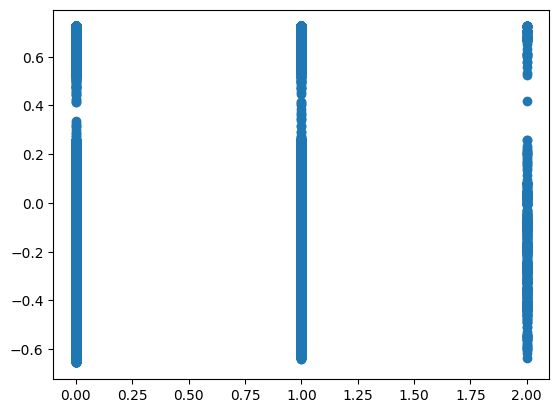

In [ ]:
### scatter plot of relevance and score
# we expect a higher predicted ranking vor values 1 and 2 on x - axis
plt.scatter(y_test_df["relevance"], y_test_df["predicted_scores"])

y_test_df.shape # can this plot be made for a specific search

In [ ]:
# calculate average predicted score by group

y_test_df.groupby(by = "relevance").mean()

,predicted_scores,qid
relevance,,
0,-0.304758,48851.244544
1,0.037793,48668.238597
2,-0.034879,51242.193825


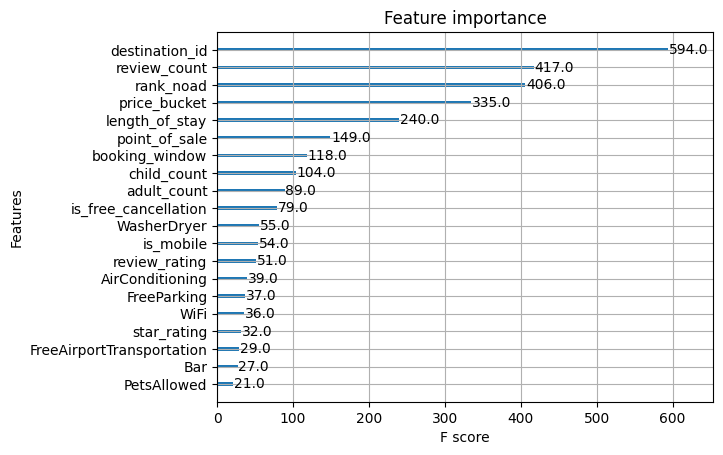

In [ ]:
#### show feature importance
from xgboost import plot_importance
# from matplotlib import pyplot

plot_importance(ranker, max_num_features=20)
plt.show()

# include label names
